# EDA

- Os Notebook [1. EDA](1.%20EDA.ipynb) e [2. Features](2.%20Criando%20as%20features.ipynb) são a base para as análises e aplicações que serão feitas posteriormente.

# Ìndice

1. [Resumo e objetivo](#Resumo-e-Objetivo)
- [EDA Básicas](#EDA-Básica)

### Coisas a serem feitas:

- [ ] Colocar todas as referências.
- [ ] Fazer o resumo.
- [ ] Colocar o link pra correlação usando mais features.
- [ ] Explicar boxplot.

# Carregando os arquivos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

import datetime

from sklearn.preprocessing import LabelEncoder

path = 'data'

train = pd.read_csv(path + '/sales_train.csv.gz')
test = pd.read_csv(path + '/test.csv.gz').set_index('ID')
items = pd.read_csv(path + '/items.csv')
items_cat = pd.read_csv(path + '/item_categories.csv')
shops = pd.read_csv(path + '/shops.csv')

# Resumo e Objetivos

#### Reunindo o o dataset.

In [2]:
train_full = pd.merge(train, items, on='item_id', how='left')
train_full = pd.merge(train_full, items_cat, on='item_category_id', how='left')
train_full = pd.merge(train_full, shops, on='shop_id', how='left')

In [3]:
train_full.date=train_full.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [4]:
train = train_full.drop(['date', 'item_name', 'shop_name', 'item_category_name'], axis=1)

----------------------

# EDA Básica

Fazer uma EDA simples é sempre um bom começo.

    - Nan's
    - Pandas
    - Outsiders

A cara do nosso dataset sem as features categóricas.

In [5]:
train.head()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,0,59,22154,999.00,1.0,37
1,0,25,2552,899.00,1.0,58
2,0,25,2552,899.00,-1.0,58
3,0,25,2554,1709.05,1.0,58
4,0,25,2555,1099.00,1.0,56


In [6]:
train.shape

(2935849, 6)

Testando se existe algum Nan ou Null no dataset.

In [7]:
print(train.isna().any())
print(train.isnull().any())

date_block_num      False
shop_id             False
item_id             False
item_price          False
item_cnt_day        False
item_category_id    False
dtype: bool
date_block_num      False
shop_id             False
item_id             False
item_price          False
item_cnt_day        False
item_category_id    False
dtype: bool


 <a name="backnan"></a> Parece que o dataset tá Ok. Mesmo assim vamos visualizar essas coisas. Linhas horizontais brancas significam Nans, como não temos nenhum tudo vai ficar cinza.

Deixei um exemplo [aqui](#nan) caso queira ver como fica um dataset com Nans.

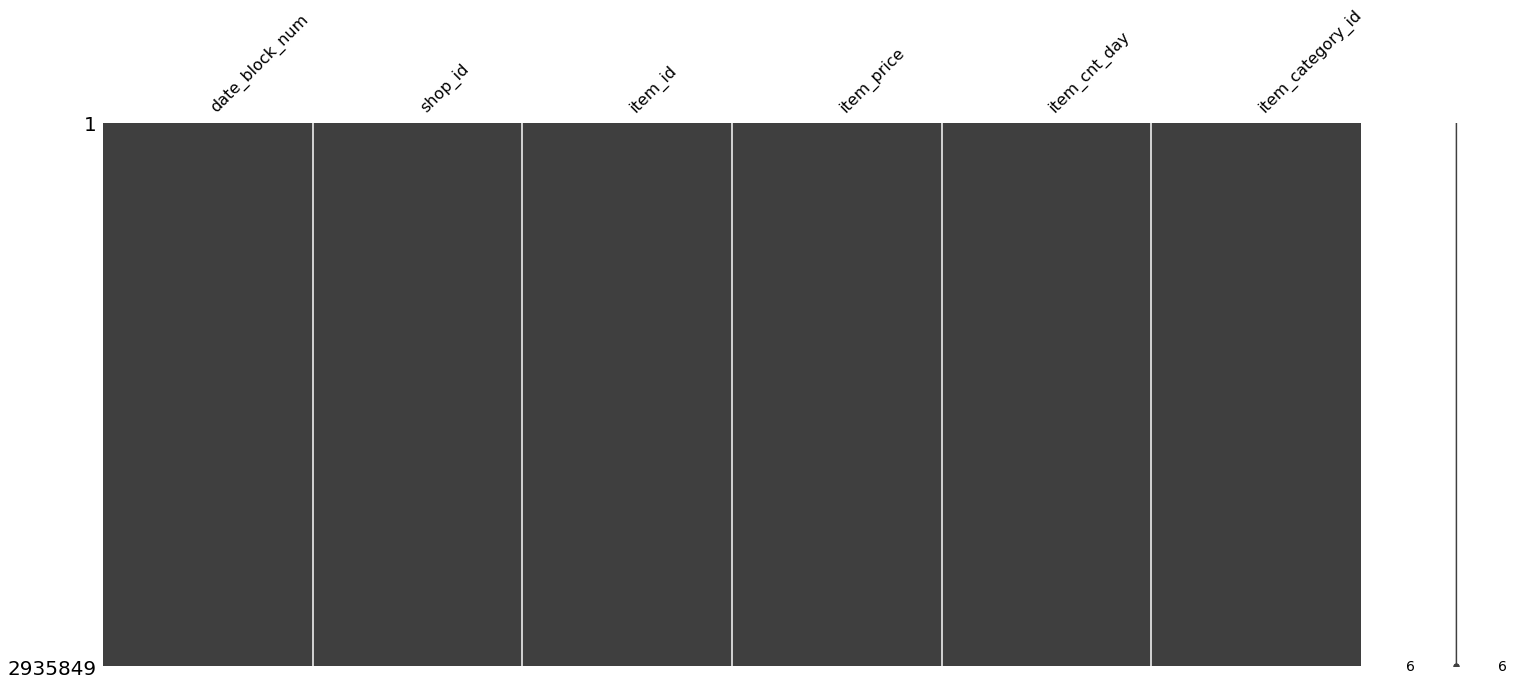

In [8]:
msno.matrix(train.loc[:, :])
plt.show()

Número de coisas únicas, como shoppings e itens.

In [9]:
print('Meses:', train['date_block_num'].nunique())
print('Shoppings:', train['shop_id'].nunique())
print('Itens:', train['item_id'].nunique())
print('Categórias:', train['item_category_id'].nunique())

Meses: 34
Shoppings: 60
Itens: 21807
Categórias: 84


> Temos poucos meses no dataset, isso pode ser um problema porque temos poucos dados para serem dividos em treino e teste.

O mapa de correlações serve para ver como as features variam uma em relação a outra. Por exemplo, o preço de uma casa vai estar correlacionado ao seu tamanho, uma correlação positiva. Se o preço da casa é alto o preço também vai ser.

Mais pra baixo vamos usar outras features e elas vão estar correlacionadas e veremos um gráfico mais interessante. [features corr.]()

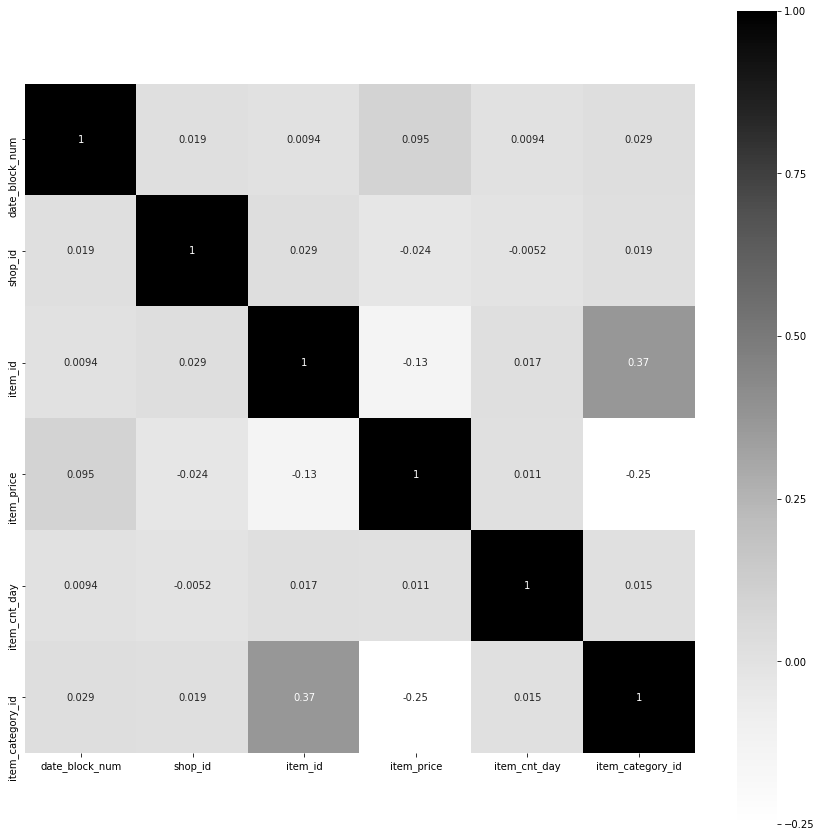

In [10]:
correlation = train.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation, vmax=1, square=True,annot=True, cmap='Greys')
plt.show()

Agora vamos pra estatística de verdade usando o pandas.

In [11]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00,4.000138e+01
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00,1.710076e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,0.000000e+00
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00,2.800000e+01
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00,4.000000e+01
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00,5.500000e+01
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03,8.300000e+01


**Obs.:**
- O minímo do item_price é negativo. (Provavelmente uma promoção ou coisa do tipo)
- O minímo do item_cnt_day é negativo. (Provavelmente são devoluções)
- O máximo do item_price é bem alto. (Um dos itens tem valor elevado demais)
- O máximo do item_cnt_day é bem alto. (Venderam um monte de itens de uma vez)
- O desvio padrão std dos dois também está meio alto. (Isso pode gerar problemas em alguns modelos)

> De forma geral todos os itens destacados podem causar problemas para os modelos que vão ser usados.

Vamos montar alguns gráficos de histogramas. Histogramas agrupam valores repetidos, então a altura da barra no gráfico indica quantas vezes aquele valor apareceu.

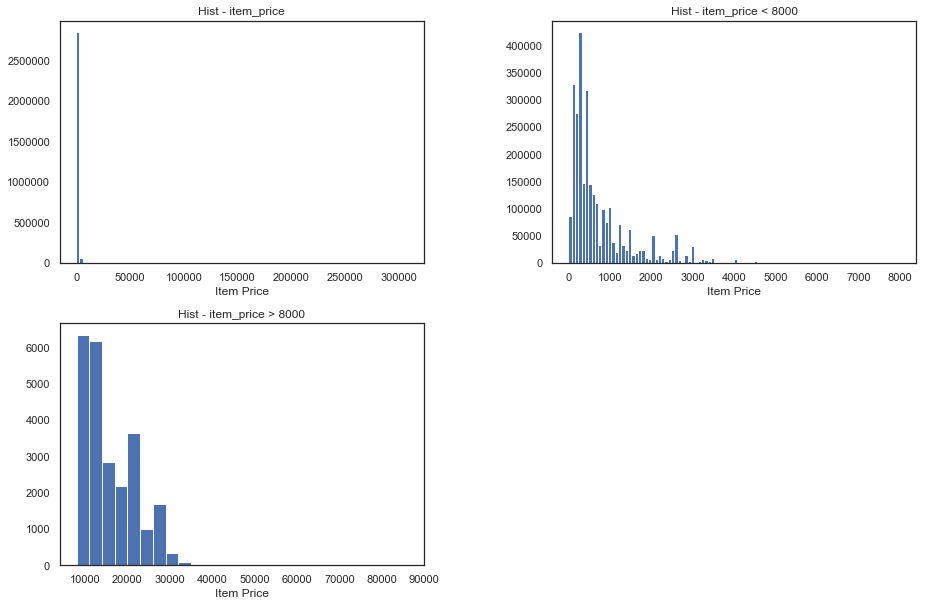

In [130]:
plt.figure(1, figsize=(14,9))

plt.subplot(221)
plt.hist(train_full['item_price'], bins = 100)
plt.title('Hist - item_price')
plt.xlabel('Item Price')

plt.subplot(222)
plt.hist(train_full['item_price'][train_full.item_price < 8000], bins = 100)
plt.title('Hist - item_price < 8000')
plt.xlabel('Item Price')

plt.subplot(223)
plt.hist(train_full['item_price'][train_full.item_price > 8000], bins = 100)
plt.title('Hist - item_price > 8000')
plt.xlim(4000, 90000)
plt.xlabel('Item Price')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

- O primeiro gráfico não diz muito. Só me fala que muitos itens tem valores pequenos.
- O segundo gráfico (valores < 8000), me mostra que realmente são vendidos mais itens com valores baixos. 
- O terceiro gráfico (valores > 8000), poucas vendas de itens caros, apesar de ter $6.000$ vendas de itens que valem mais de $10.000$.

Uma forma melhor de observar se existem itens com valores muito discrepantes, é utilizando o plot de caixas.

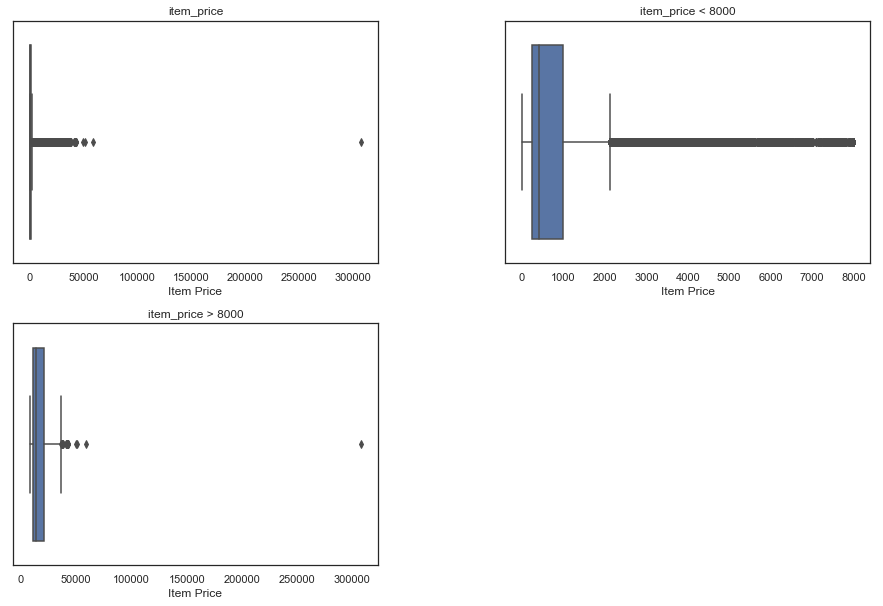

In [160]:
plt.figure(1, figsize=(14,9))

plt.subplot(221)
sns.boxplot(x = train['item_price'])
plt.title('item_price')
plt.xlabel('Item Price')

plt.subplot(222)
sns.boxplot(train['item_price'][train.item_price < 8000])
plt.title('item_price < 8000')
plt.xlabel('Item Price')

plt.subplot(223)
sns.boxplot(train['item_price'][train.item_price > 8000])
plt.title('item_price > 8000')
#plt.xlim(4000, 90000)
plt.xlabel('Item Price')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

- No primeiro e no terceiro gráfico já da pra ver o valor discrepante.
- Deixei um [link][box] onde tem um explicação sobre o boxplot 

[box]: http://www.abgconsultoria.com.br/blog/boxplot-como-interpretar/

O item_cnt_day também vai ter outliers, como é esperado.

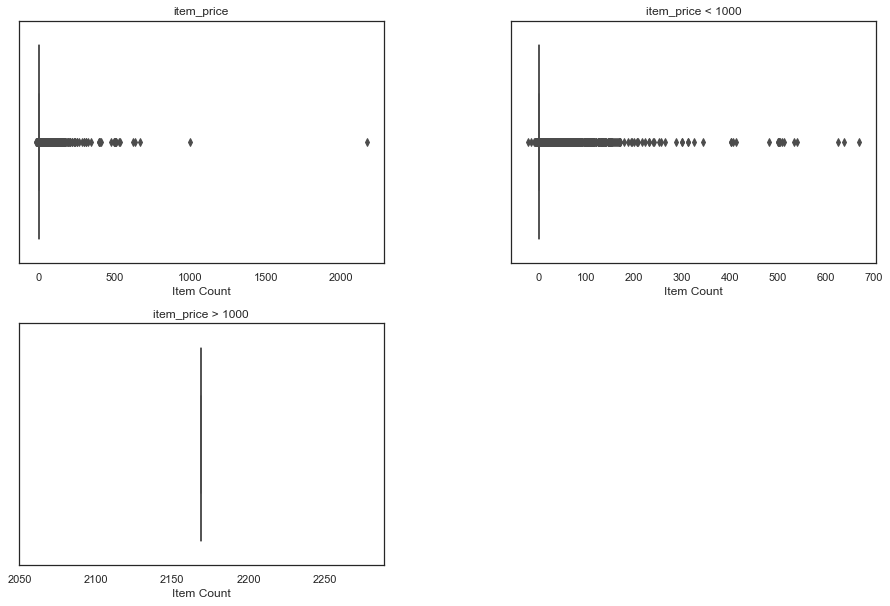

In [156]:
plt.figure(1, figsize=(14,9))

plt.subplot(221)
sns.boxplot(x = train['item_cnt_day'])
plt.title('item_price')
plt.xlabel('Item Count')

plt.subplot(222)
sns.boxplot(train['item_cnt_day'][train.item_cnt_day < 1000])
plt.title('item_price < 1000')
plt.xlabel('Item Count')

plt.subplot(223)
sns.boxplot(train['item_cnt_day'][train.item_cnt_day > 1000])
plt.title('item_price > 1000')
#plt.xlim(4000, 90000)
plt.xlabel('Item Count')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

- Comparando o segundo e o terceiro gráfico, parece que só existe um outliers e está acima de mil.

In [158]:
train[train.item_cnt_day > 1000]

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
2909818,33,12,11373,0.908714,2169.0,9


Vamos ver quais categórias vendem mais itens.

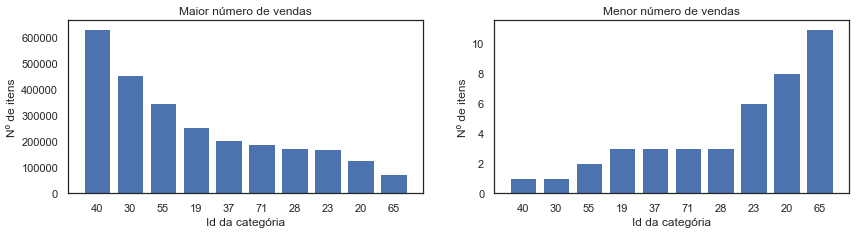

In [272]:
df = train[['item_category_id', 'item_cnt_day']].groupby(
    ['item_category_id']).sum()

large = df.nlargest(n=10,columns=['item_cnt_day']).reset_index()
small = df.nsmallest(n=10,columns=['item_cnt_day']).reset_index()

x = np.linspace(1,10,10)

plt.figure(1, figsize=(14,7))

plt.subplot(221)
plt.bar(x, large['item_cnt_day'])
plt.xticks(x, large['item_category_id'])
plt.title('Maior número de vendas')
plt.xlabel('Id da categória')
plt.ylabel('Nº de itens')

plt.subplot(222)
plt.bar(x, small['item_cnt_day'])
plt.xticks(x, large['item_category_id'])
plt.title('Menor número de vendas')
plt.xlabel('Id da categória')
plt.ylabel('Nº de itens')

plt.show()

In [289]:
df = train[['item_category_id','date_block_num', 'item_cnt_day']].groupby(
    ['date_block_num', 'item_category_id']).sum()



date_block_num  item_category_id
0               0                       1.0
                1                       1.0
                2                    1390.0
                3                     440.0
                4                     251.0
                5                     623.0
                6                     870.0
                9                     149.0
                11                    375.0
                13                     84.0
                14                    143.0
                15                    268.0
                18                      3.0
                19                   8983.0
                21                   3492.0
                22                   1286.0
                23                   4150.0
                25                    641.0
                28                   5435.0
                29                    308.0
                30                  22216.0
                33                    291.0

In [167]:
df = train.pivot_table(index=['item_category_id', 'shop_id'],
                       columns=['date_block_num'], values=['item_cnt_day'], aggfunc='sum', fill_value=0)

item_cnt_day                                     ...  \
date_block_num                     0   1   2   3   4   5   6   7   8   9  ...   
item_category_id shop_id                                                  ...   
0                0                  0   1   0   0   0   0   0   0   0   0 ...   
                 25                 1   0   0   0   0   0   0   0   0   0 ...   
                 38                 0   0   0   1   0   0   0   0   0   0 ...   
1                0                  0   1   0   0   0   0   0   0   0   0 ...   
                 45                 1   0   0   0   0   0   0   0   0   0 ...   
2                0                 53  52   0   0   0   0   0   0   0   0 ...   
                 1                 39  24   0   0   0   0   0   0   0   0 ...   
                 2                 25  21  10  15   8  15  14  18  13  14 ...   
                 3                 15   6   3   8   5   3  11   4   6   5 ...   
                 4                 22  15  18   2   6   8  10   6   9  13 ...   
                 5                  0   2  17   5   8  10   6   9  11   5 ...   
                 6                 43  24  17  11  13  14  16  24  21  21 ...   
                 7                 34  29  24  12  14  15   7  12  15  11 ...   
                 8                 10   5   4   0   0   0   0   0   0   0 ...   
                 9                  0   0   0   0   0   0   0   0   0  32 ...   
                 10                 7  11   3   0   5   1  11   3  11   4 ...   
                 11                 0   0   0   0   0   0   0   0   0   0 ...   
                 12                 5  17   6  17   6   4   6  19   5  10 ...   
                 14                21  11   8   7   8   8   8   4   4   6 ...   
                 15                30  24  16   7   6  13   7  15  14  16 ...   
                 16                25  26  26  14  10   9  10  13  12  20 ...   
                 17                 0   0   0   0   0   8   5  14  15   9 ...   
                 18                58  64  47  34  34  37  33  19  40  26 ...   
                 19                47  18  20  15  13   8  18   9  25  19 ...   
                 21                 5  12  10   9   8   5   4  11   7   5 ...   
                 22                 4  19  11   5   2   9   3   5   5   4 ...   
                 23                12  25  26  13   0   0   0   0   0   0 ...   
                 24                13  16  10   4  13  19  18  17  21   9 ...   
                 25                62  69  65  47  31  27  23  47  43  58 ...   
                 26                17  27  20  17  12  12  19  11  19   7 ...   
...                               ...  ..  ..  ..  ..  ..  ..  ..  ..  .. ...   
83               27                26   6  16  15   5   0   0   0   0   0 ...   
                 28                42  15  20  17  28  64  55  53   9   0 ...   
                 29                 0   0   0   0   0   0   0   0   0   0 ...   
                 30                33  10  10  15   7  21  21   7   1   0 ...   
                 31               110  58  63  73  60  73  35   0   0   0 ...   
                 33                 0   0   0   0   0   0   0   0   0   0 ...   
                 34                 0   0   0   0   0   0   0   0   0   0 ...   
                 35                 0   0   0   0   0   0   0   0   0   0 ...   
                 36                 0   0   0   0   0   0   0   0   0   0 ...   
                 37                36  22  26  21  17   9   6   0   0   0 ...   
                 38                 0   0  10   0   3   2   0   0   0   0 ...   
                 39                 0   0   0   0   0   0   0   0   0   0 ...   
                 41                27  23  12   4   5   1   3   0   0   0 ...   
                 42                28  30  18  10   6  16  16   0   0   0 ...   
                 43                 8   4  10   3   6  13  23  13  17  11 ...   
                 44                31  18  15  19  39  3

# Apéndice

#### <a name="nan"></a> Criando o dataframe com nans para ser visualizado.

[Voltar ao notebook](#backnan)


In [ ]:
a = np.zeros((10,4))
a[4, :] = np.nan
a[8, :] = np.nan

a = pd.DataFrame(a)

In [ ]:
msno.matrix(a)

Mapa de correlações dos nans.

In [ ]:
msno.heatmap(a)
plt.show()

# Referências